# EX18. 문자를 읽을 수 있는 딥러닝

> 평가문항
> - OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?
> - 모델 평가기준이 명확하고 체계적으로 세워졌는가?
> - 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?

## 1. 검증용 데이터셋 준비

In [12]:
import os

img_dir = os.getenv('HOME')+'/aiffel/data_files/restaurants'
restaurants = os.listdir(img_dir)
restaurants

['san2.jpg',
 '15.jfif',
 'bike.jpg',
 'las3.jfif',
 '3.jpg',
 'las2.jpg',
 '7.jpg',
 'sign.jfif',
 '12.jpg',
 'san.jpg',
 '6.jfif',
 '4.jpg',
 '10.jpg']

## 2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

### 1) keras-ocr

In [13]:
import matplotlib.pyplot as plt
import keras_ocr

In [14]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
# 인식을 위한 파이프라인을 생성하는데 이때 초기화 과정에서 미리 학습된 모델의 가중치(weight)를 불러온다.
pipeline = keras_ocr.pipeline.Pipeline()

images = [keras_ocr.tools.read(os.path.join(img_dir, restaurant)) for restaurant in restaurants]
prediction_groups = [pipeline.recognize([os.path.join(img_dir, restaurant)]) for restaurant in restaurants]

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


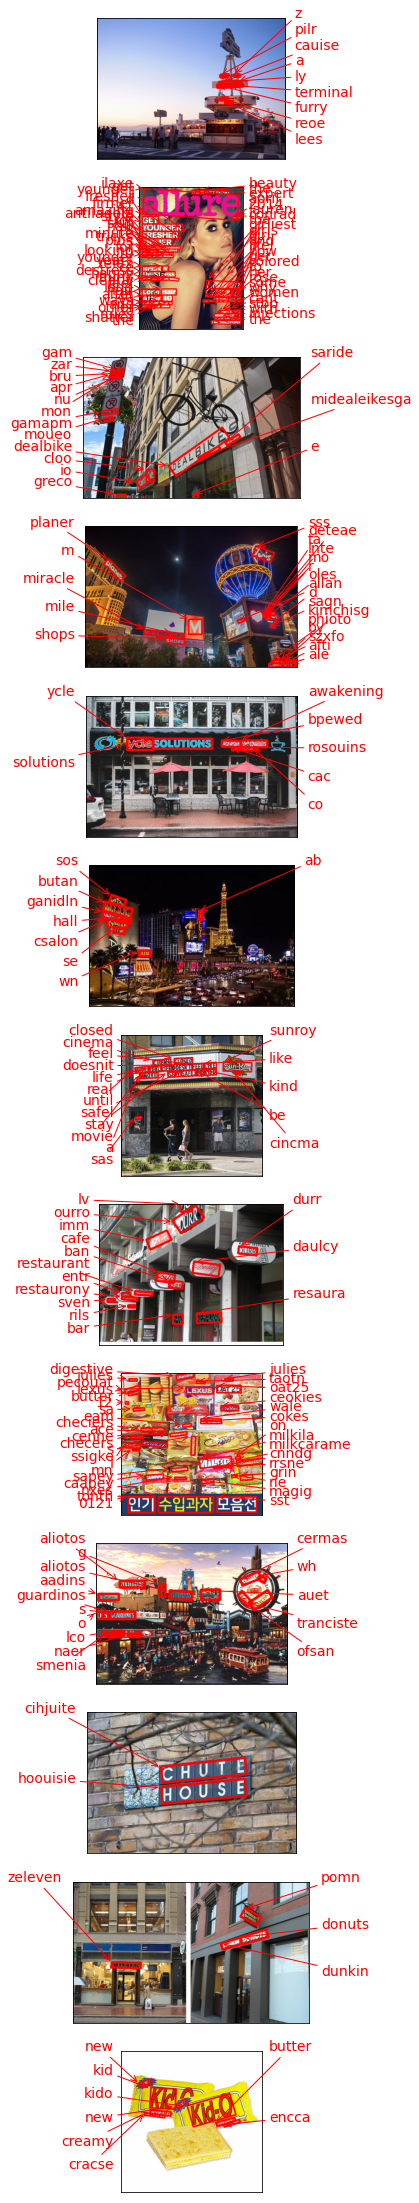

In [15]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(40, 40))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 2)  Tesseract OCR

In [33]:
def recognize_images(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")

            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1

    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [34]:
save_dir = os.getenv('HOME')+'/aiffel/data_files/restaurants/'

for restaurant in restaurants:
    print(f'[{restaurant}]')
    try:
        recognize_images(os.path.join(img_dir, restaurant), save_dir)
    except:
        print(f'Cannot recognize characters from {restaurant}')

[san2.jpg]
r,s, i, I , , ,  ,  ,  ,  ,  ,  ,  ,  , ,  S,  , i ,  ,  ,  as


Done
[15.jfif]
APRIL 2014

;

Done
[bike.jpg]

Done
[las3.jfif]

Done
[3.jpg]

Done
[las2.jpg]
Cannot recognize characters from las2.jpg
[7.jpg]



|e

ee

.

CINEMA

CLOSED

|

} UNTIL

REAL

LIFE

DOESN!

FEEL

LIKE

dry

A MOVIE

STAY

SAFE.


KIND

|

a=


Press siti e ete Loe

PE

Done
[sign.jfif]
Cannot recognize characters from sign.jfif
[12.jpg]
oe

Done
[san.jpg]

Done
[6.jfif]
ai

Done
[4.jpg]
Cannot recognize characters from 4.jpg
[10.jpg]
- : Ke

Done


*************************

In [31]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/data_files/restaurants'
img_file_path = work_dir + '/10.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/data_files/restaurants/0000.png


- **인식하는 사진을 찾아내기까지 굉장히 오래 걸렸다.**

- 한국어를 쓸 때 테서랙트의 언어팩 설치해야 정상적으로 동작.

    - $ sudo apt install tesseract-ocr-kor

In [32]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

- : Ke

Done


## 3) Google OCR

In [ ]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [ ]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json.json'


# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for restaurant in restaurants:
    print(f'[{restaurant}]')
    detect_text(os.path.join(img_dir, restaurant))
    print()

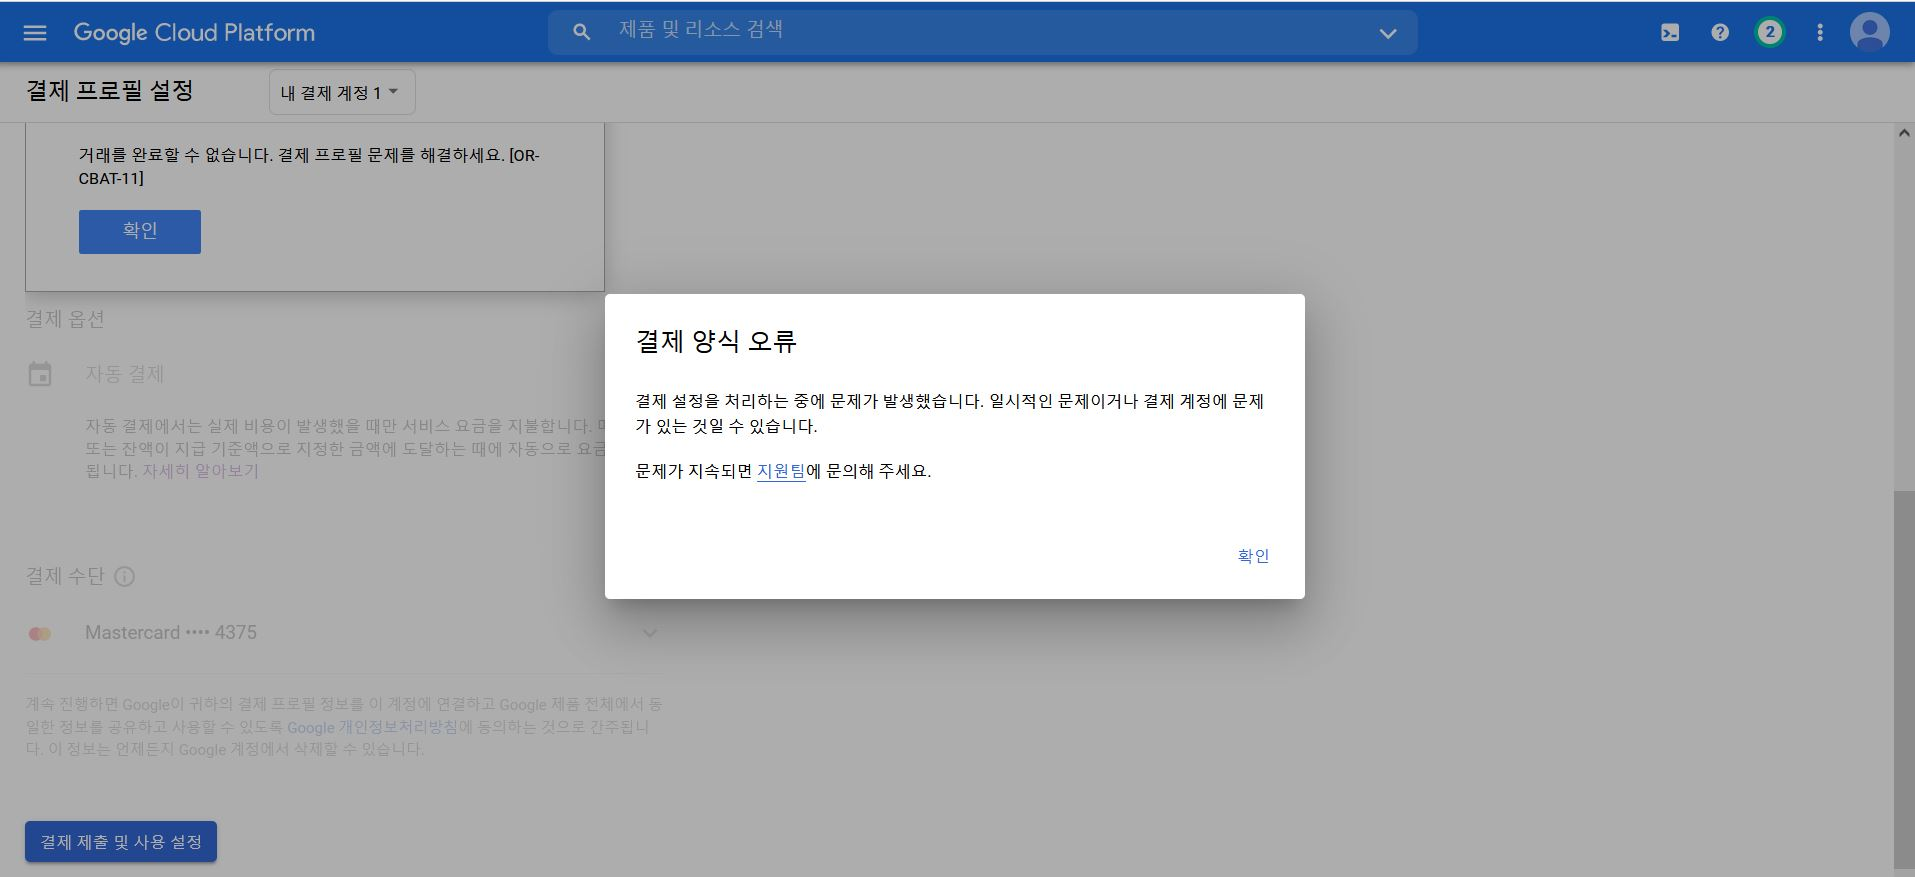

- 결제 등록에 문제가 있어, Google OCR은 생략.....

## 3. 테스트 결과 정리
- 비교하는 함수

In [35]:
def compare_ocr(restaurant):
    print('[keras-ocr]')
    idx = restaurants.index(restaurant)
    keras_ocr.tools.drawAnnotations(image=images[idx], predictions=prediction_groups[idx][0])
    plt.show()
#    print('[Google OCR]')
#    detect_text(os.path.join(img_dir, restaurant))
# Google OCR은 생략
    print('[Tesseract]')
    recognize_images(os.path.join(img_dir, restaurant), save_dir)   

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


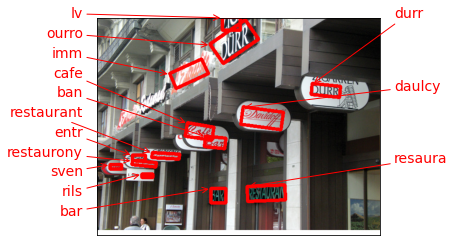

[Tesseract]


SystemError: tile cannot extend outside image

In [36]:
compare_ocr('sign.jfif')  

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


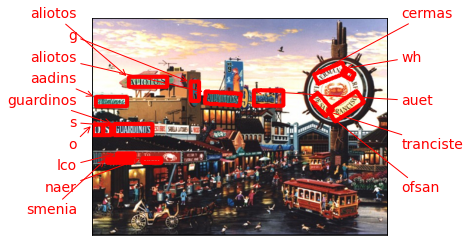

[Tesseract]

Done


In [37]:
compare_ocr('san.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


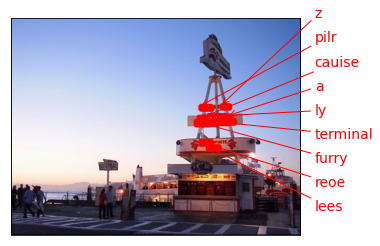

[Tesseract]
r,s, i, I , , ,  ,  ,  ,  ,  ,  ,  ,  , ,  S,  , i ,  ,  ,  as


Done


In [38]:
compare_ocr('san2.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


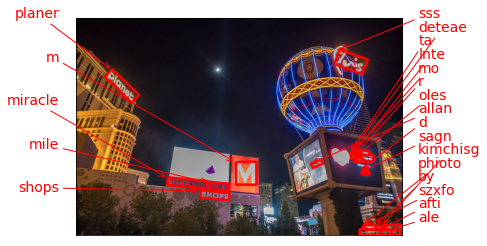

[Tesseract]

Done


In [39]:
compare_ocr('las3.jfif')  

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


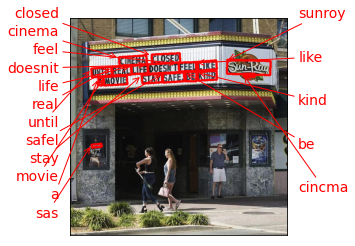

[Tesseract]



|e

ee

.

CINEMA

CLOSED

|

} UNTIL

REAL

LIFE

DOESN!

FEEL

LIKE

dry

A MOVIE

STAY

SAFE.


KIND

|

a=


Press siti e ete Loe

PE

Done


In [40]:
compare_ocr('7.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


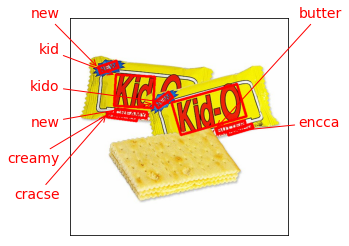

[Tesseract]
- : Ke

Done


In [41]:
compare_ocr('10.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


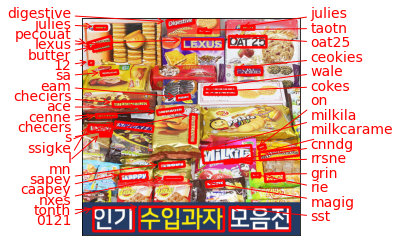

[Tesseract]
oe

Done


In [43]:
compare_ocr('12.jpg')

[keras-ocr]


/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


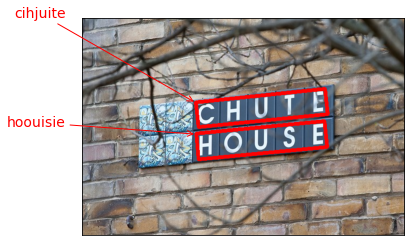

[Tesseract]
ai

Done


In [44]:
compare_ocr('6.jfif')

# 회고
- keras-ocr은 문자를 소문자로 인식한다. 대체적으로 정확도가 많이 떨어진다. box는 비교적 잘 표시하지만, 전혀 다른 알파벳으로 인식을 하기 때문에 개선이 필요하다. 

- tesseract는 정확도가 낮고, 대부분 단어들을 인식하지 못하고, 단어가 있는 부분의 frame조차 제대로 잡아주지 못해 SystemError: tile cannot extend outside image가 많이 떴고, 다양한 이미를 선택했지만, 제대로 된 결과를 보지 못했다. tesseract는 아직 상용화와 거리가 많이 멀다.

	- (알아본 결과, 구글 OCR이 띄어쓰기도 가장 잘 잡아내고 대소문자까지 구분한다고 한다. 나머지 둘 OCR에 비해 성능이 좋다. 그 뿐만 아니라, 대체적으로 정확하게 글씨를 잡아낸다. 역시나, 3차원으로 기울어진 문자를 인식하는 데에는 취약하다. 또한 세로로 된 글자는 아예 인식 못한다.)

### 결론은 구글 OCR 빼고는 쓸만한게 없는것 같다.....